#### Torch CNN - CIFAR10

In [1]:
import PIL
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms

import os, sys
from pathlib import Path
sys.path.append(str(Path('.ipynb').resolve().parents[2]))

BATCH_SIZE = 128
DOWNLOAD = False
SUBSET = 0

train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load dataset
train_dataset = torchvision.datasets.CIFAR10(root='/home/tung5534/cnn_cifar/data', 
                                            train=True,
                                            download=DOWNLOAD,
                                            transform=train_transform,
                                            )
test_dataset = torchvision.datasets.CIFAR10(root='/home/tung5534/cnn_cifar/data', 
                                            train=False,
                                            download=DOWNLOAD,
                                            transform=test_transform,
                                            )
if SUBSET != 0:
    subset_indices = list(range(SUBSET))
    train_set = torch.utils.data.Subset(train_dataset, subset_indices)
    test_set = torch.utils.data.Subset(test_dataset, subset_indices)
    print(f'Using subset of {SUBSET} samples')
else:
    train_set, test_set = train_dataset, test_dataset
    print('Using full dataset')

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# Class names
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Using full dataset
cuda


In [2]:
def save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_acc, run_times,
                     n_step):
    import os
    import json

    if not os.path.exists(save_path):
        os.makedirs(save_path)
    if n_step < 1:
        lr = str(n_step).replace(".","")
        
    performance = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_errs': train_errs,
        'test_errs': test_errs,
        'train_accs': train_accs,
        'test_acc': test_acc,
        'run_time': run_times,
        'n_step': n_step
    }
    with open(f'{save_path}/FISTA_5steps_lr_{n_step}.json', 'w') as f:
        json.dump(performance, f, indent=4)    

In [3]:
def evaluate_model(model, criterion, test_loader=test_loader):
    model.eval()
    _test_acc, _test_err, _test_loss, total_test = 0, 0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                _test_acc += (predicted == labels).sum().item()
                _test_err += (predicted != labels).sum().item()
                _test_loss += criterion(outputs, labels).item()

    test_loss = _test_loss / total_test
    test_err = 100 * _test_err / total_test
    test_acc = 100 * _test_acc / total_test

    return test_loss, test_err, test_acc

In [4]:
# import torch
# from torch.optim.optimizer import Optimizer

# class FISTA(Optimizer):
#     def __init__(self, params, lr=1e-3, ministeps = 5):
#         defaults = dict(lr=lr, ministeps=ministeps)
#         super(FISTA, self).__init__(params, defaults)

#         for group in self.param_groups:
#             group['y'] = [p.clone().detach() for p in group['params']]
#             group['k'] = 1

#     def step(self, closure=None):
#         if closure is None:
#             raise RuntimeError("FISTA requires a closure to recompute gradients.")
        
#         loss = None
#         for group in self.param_groups:
#             lr, ministeps = group['lr'], group['ministeps']

#             # Loop over ministeps
#             for _ in range(ministeps):
# #                 k = group['k']
#                 k = 1

#                 with torch.enable_grad():
#                     loss = closure()

#                 # Reset, k=1, update p
#                 for i, p in enumerate(group['params']):
#                     if p.grad is None:
#                         continue

#                     x_k = p.data
#                     y_k = group['y'][i].data

#                     # y_k grad
#                     grad_y = p.grad.data

#                     # x_{k+1} = y_k - t * grad(f(y_k))
#                     x_next = y_k - lr * grad_y
#                     # Question: Should we update multi-step here, inside the loop

#                     #  y_{k+1} = x_{k+1} + (k / (k + 3)) * (x_{k+1} - x_k)
#                     momentum_coeff = (k) / (k + 3)
#                     y_next = x_next + momentum_coeff * (x_next - x_k)

#                     # Update
#                     p.data = x_next
#                     group['y'][i].data = y_next
            
# #             group['k'] += 1

#         return loss


In [4]:
import time
from models import SimpleCNN
from optim.fista_multi_wo_prox import FISTA

def modeling(n_epochs=100, lr=0.01, threshold=90):
    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = FISTA(model.parameters(), lr=lr, ministeps = 5)
    
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = [], [], [], [], [], [], []

    for i, epoch in enumerate(range(n_epochs)):
        print(f"Epoch: {i+1}/{n_epochs}")
        model.train() 
        total_train, _train_err, _train_acc, running_loss, run_time = 0, 0, 0, 0.0, 0
        _start = time.time()

        def closure():
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            return loss

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Forward
            optimizer.zero_grad()
            outputs = model(images)
            # Backward
            loss = optimizer.step(closure)

            # Log Losses and Training accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            _train_err += (predicted != labels).sum().item()
            _train_acc += (predicted == labels).sum().item()

        run_time = time.time() - _start
        
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = 100 * _train_acc / total_train
        epoch_train_err = 100 * _train_err / total_train
        
        test_loss, test_err, test_acc = evaluate_model(model, criterion, test_loader)

        train_losses.append(epoch_train_loss)
        train_errs.append(epoch_train_err)
        train_accs.append(epoch_train_acc)
        test_losses.append(test_loss)
        test_errs.append(test_err)
        test_accs.append(test_acc)
        run_times.append(run_time)

        if epoch % 1 == 0:
            print(f'E [{epoch+1}/{n_epochs}]. train_loss_acc: {running_loss / len(train_loader):.4f}, {epoch_train_acc:.2f}%, '
                    f'test_acc: {test_acc:.2f}%, run_time: {round(run_time, 2)} seconds')
        if epoch_train_acc >= threshold:
            print(f"Early stopping at epoch {epoch+1} with train error {epoch_train_err:.2f}%")
            break
    return train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times

Epoch: 1/30
E [1/30]. train_loss_acc: 1.8348, 33.62%, test_acc: 44.13%, run_time: 11.83 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 1.4554, 44.82%, test_acc: 50.46%, run_time: 10.99 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 1.2954, 49.35%, test_acc: 54.83%, run_time: 10.96 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 1.1946, 52.85%, test_acc: 57.91%, run_time: 10.94 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 1.1104, 55.67%, test_acc: 59.23%, run_time: 10.95 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 1.0351, 57.96%, test_acc: 62.22%, run_time: 10.97 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.9751, 59.53%, test_acc: 65.48%, run_time: 10.94 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.9207, 61.54%, test_acc: 65.82%, run_time: 10.94 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.8838, 62.53%, test_acc: 64.58%, run_time: 10.94 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.8510, 63.55%, test_acc: 68.07%, run_time: 10.9 seconds
Epoch: 11/30
E [11/30]. train_loss_acc:

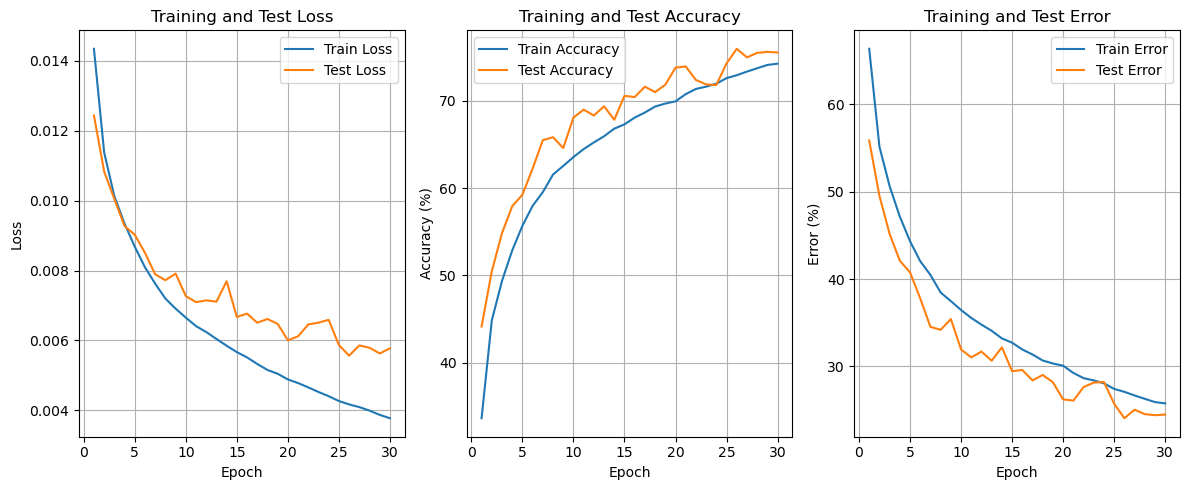

Epoch: 1/30
E [1/30]. train_loss_acc: 1.2766, 44.62%, test_acc: 52.53%, run_time: 10.99 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.8263, 56.93%, test_acc: 57.42%, run_time: 10.92 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.6599, 61.72%, test_acc: 66.75%, run_time: 10.92 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.5579, 64.70%, test_acc: 67.43%, run_time: 10.97 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.4736, 66.93%, test_acc: 69.61%, run_time: 10.96 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.3969, 69.08%, test_acc: 71.05%, run_time: 10.96 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.3348, 70.66%, test_acc: 71.17%, run_time: 10.93 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.2858, 72.19%, test_acc: 74.11%, run_time: 10.94 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.2443, 73.49%, test_acc: 73.51%, run_time: 10.96 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.2152, 74.29%, test_acc: 75.94%, run_time: 11.0 seconds
Epoch: 11/30
E [11/30]. train_loss_acc:

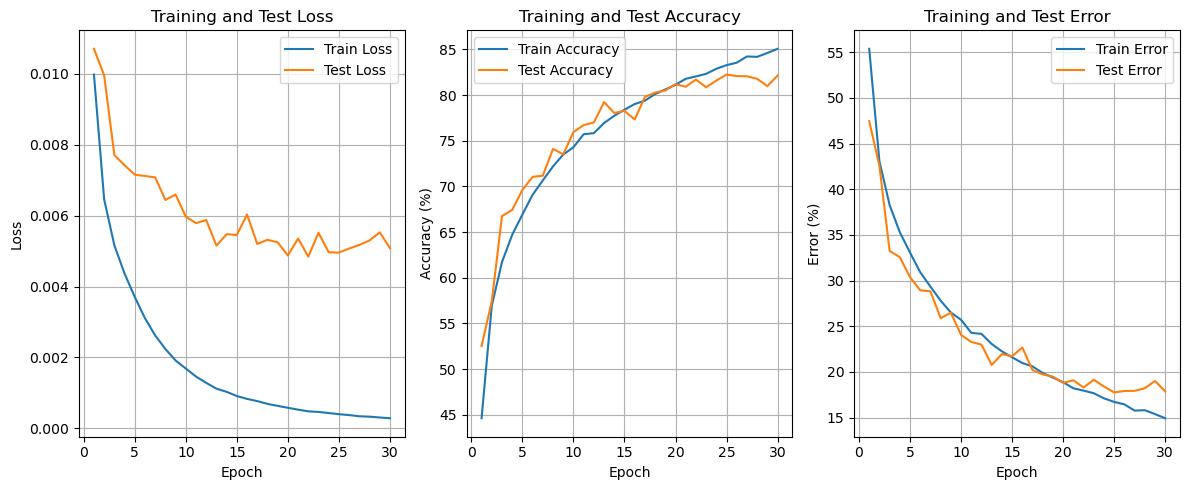

Epoch: 1/30
E [1/30]. train_loss_acc: 1.0099, 48.24%, test_acc: 60.91%, run_time: 10.92 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.5357, 61.02%, test_acc: 65.36%, run_time: 10.95 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.3572, 65.81%, test_acc: 70.44%, run_time: 11.01 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.2447, 68.43%, test_acc: 71.51%, run_time: 10.94 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.1717, 71.25%, test_acc: 72.21%, run_time: 10.94 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.1317, 72.76%, test_acc: 76.14%, run_time: 10.94 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.1063, 74.33%, test_acc: 74.70%, run_time: 10.98 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.0829, 75.52%, test_acc: 77.46%, run_time: 10.99 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.0703, 76.77%, test_acc: 76.70%, run_time: 10.94 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.0591, 77.99%, test_acc: 79.38%, run_time: 10.92 seconds
Epoch: 11/30
E [11/30]. train_loss_acc

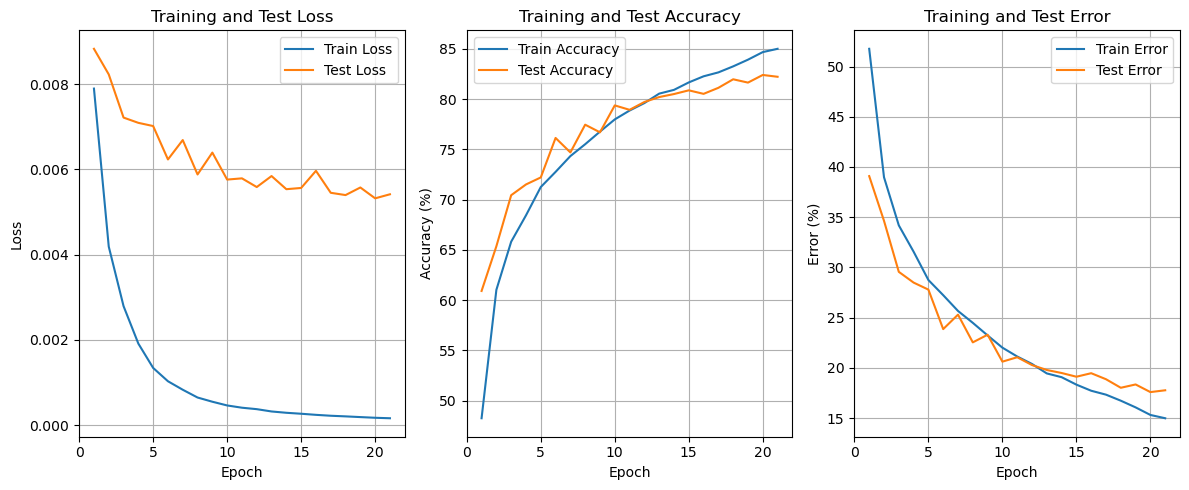

Epoch: 1/30
E [1/30]. train_loss_acc: 0.3123, 54.07%, test_acc: 67.08%, run_time: 10.92 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.0446, 67.05%, test_acc: 71.76%, run_time: 10.89 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.0293, 71.39%, test_acc: 74.14%, run_time: 10.89 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.0227, 74.44%, test_acc: 75.44%, run_time: 10.94 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.0188, 76.71%, test_acc: 77.07%, run_time: 10.97 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.0167, 77.91%, test_acc: 78.52%, run_time: 10.88 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.0146, 79.68%, test_acc: 78.42%, run_time: 10.87 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.0132, 80.90%, test_acc: 78.93%, run_time: 10.9 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.0120, 81.85%, test_acc: 80.43%, run_time: 10.94 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.0112, 82.88%, test_acc: 81.20%, run_time: 10.9 seconds
Epoch: 11/30
E [11/30]. train_loss_acc: 

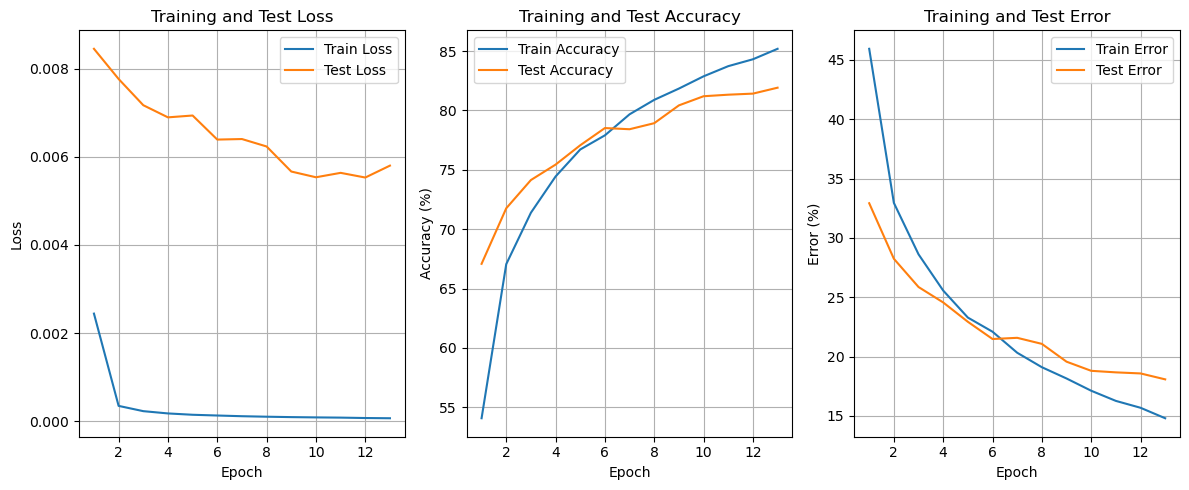

Epoch: 1/30
E [1/30]. train_loss_acc: 0.2279, 50.30%, test_acc: 64.61%, run_time: 10.98 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.0299, 64.81%, test_acc: 67.54%, run_time: 10.92 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.0233, 69.66%, test_acc: 72.20%, run_time: 10.92 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.0193, 73.22%, test_acc: 74.83%, run_time: 10.91 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.0169, 75.12%, test_acc: 74.98%, run_time: 10.95 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.0151, 76.74%, test_acc: 77.93%, run_time: 10.94 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.0135, 78.76%, test_acc: 77.76%, run_time: 10.9 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.0126, 79.71%, test_acc: 78.88%, run_time: 10.9 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.0109, 81.13%, test_acc: 79.84%, run_time: 10.92 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.0102, 82.16%, test_acc: 79.97%, run_time: 11.0 seconds
Epoch: 11/30
E [11/30]. train_loss_acc: 0

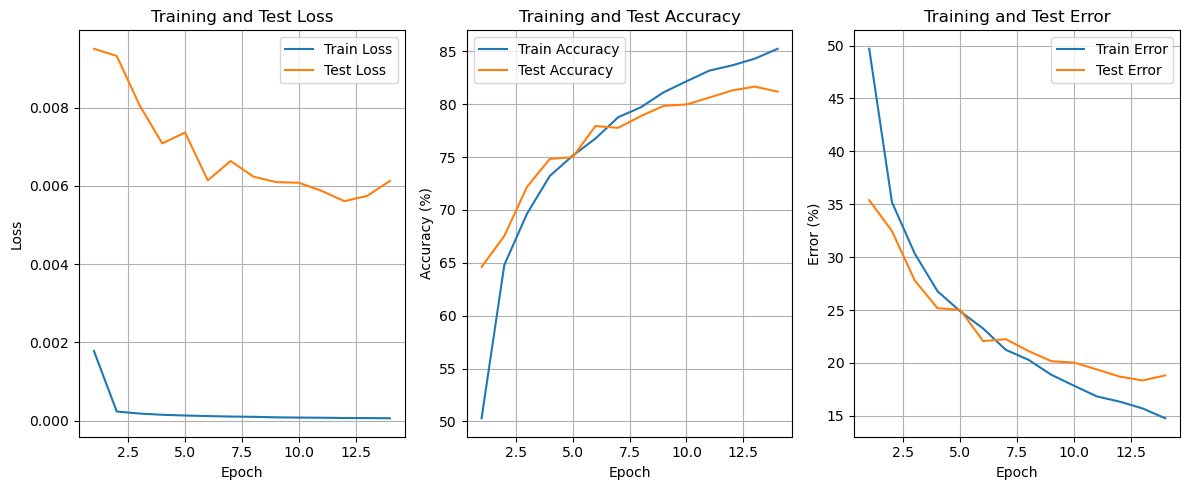

Epoch: 1/30
E [1/30]. train_loss_acc: 0.2636, 46.88%, test_acc: 58.92%, run_time: 11.05 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.0420, 61.76%, test_acc: 67.58%, run_time: 10.99 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.0325, 66.52%, test_acc: 70.98%, run_time: 10.97 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.0296, 69.67%, test_acc: 73.29%, run_time: 10.96 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.0259, 71.80%, test_acc: 72.67%, run_time: 10.87 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.0238, 73.72%, test_acc: 74.28%, run_time: 10.87 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.0215, 75.28%, test_acc: 75.40%, run_time: 11.07 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.0197, 76.44%, test_acc: 75.79%, run_time: 11.1 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.0184, 77.50%, test_acc: 75.95%, run_time: 11.15 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.0174, 78.21%, test_acc: 76.91%, run_time: 11.16 seconds
Epoch: 11/30
E [11/30]. train_loss_acc:

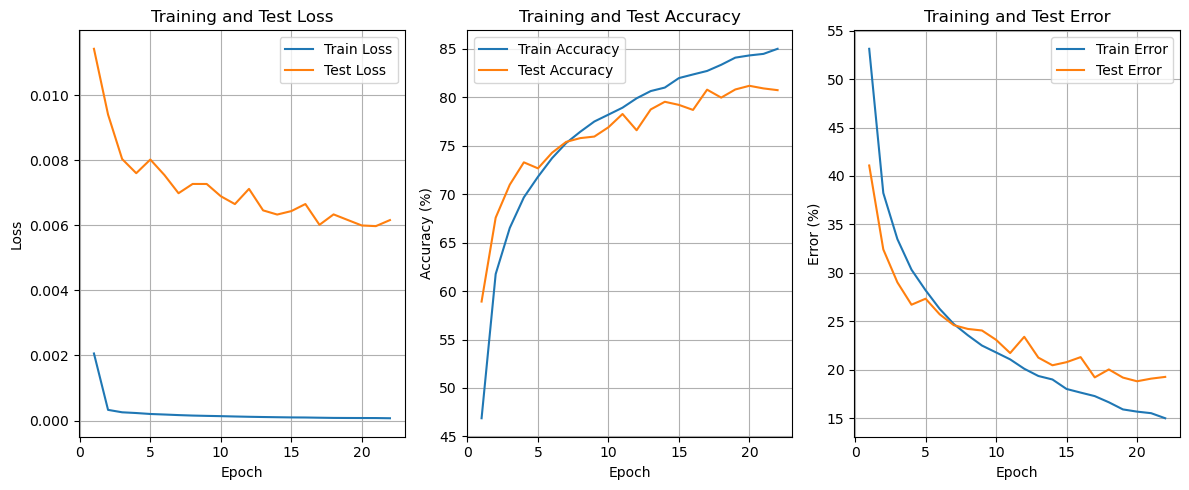

In [7]:
import numpy as np
from plot import metrics_plot

n_epochs = 30
threshold = 85
lrs = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15]
for lr in lrs:
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_epochs=n_epochs,
                                                                                              lr=lr,
                                                                                              threshold=threshold,
                                                                                             )
    save_path = f'scores/E30T85'
    save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_accs, run_times, n_step=lr,
                     )
    actual_nepochs = len(train_losses)
    metrics_plot(actual_nepochs, train_losses, test_losses, train_accs, test_accs, train_errs, test_errs)

In [6]:
import numpy as np
from plot import metrics_plot

n_epochs = 30
threshold = 85
lrs = [0.02, 0.03, 0.04, 0.06, 0.07, 0.08, 0.09]
for lr in lrs:
    train_losses, test_losses, train_errs, test_errs, train_accs, test_accs, run_times = modeling(n_epochs=n_epochs,
                                                                                              lr=lr,
                                                                                              threshold=threshold,
                                                                                             )
    save_path = f'scores/E30T85'
    save_performance(save_path,
                     train_losses, test_losses, train_errs, 
                     test_errs, train_accs, test_accs, run_times, n_step=lr,
                     )

Epoch: 1/30
E [1/30]. train_loss_acc: 0.7019, 51.27%, test_acc: 65.61%, run_time: 11.08 seconds
Epoch: 2/30
E [2/30]. train_loss_acc: 0.2086, 63.93%, test_acc: 69.29%, run_time: 10.78 seconds
Epoch: 3/30
E [3/30]. train_loss_acc: 0.1004, 68.90%, test_acc: 71.43%, run_time: 10.77 seconds
Epoch: 4/30
E [4/30]. train_loss_acc: 0.0673, 71.93%, test_acc: 75.02%, run_time: 10.77 seconds
Epoch: 5/30
E [5/30]. train_loss_acc: 0.0481, 74.40%, test_acc: 76.35%, run_time: 10.76 seconds
Epoch: 6/30
E [6/30]. train_loss_acc: 0.0399, 76.02%, test_acc: 76.98%, run_time: 10.77 seconds
Epoch: 7/30
E [7/30]. train_loss_acc: 0.0332, 77.22%, test_acc: 79.04%, run_time: 10.77 seconds
Epoch: 8/30
E [8/30]. train_loss_acc: 0.0287, 78.70%, test_acc: 78.48%, run_time: 10.77 seconds
Epoch: 9/30
E [9/30]. train_loss_acc: 0.0252, 79.91%, test_acc: 78.63%, run_time: 10.73 seconds
Epoch: 10/30
E [10/30]. train_loss_acc: 0.0231, 80.82%, test_acc: 79.06%, run_time: 10.74 seconds
Epoch: 11/30
E [11/30]. train_loss_acc

### Plot performance

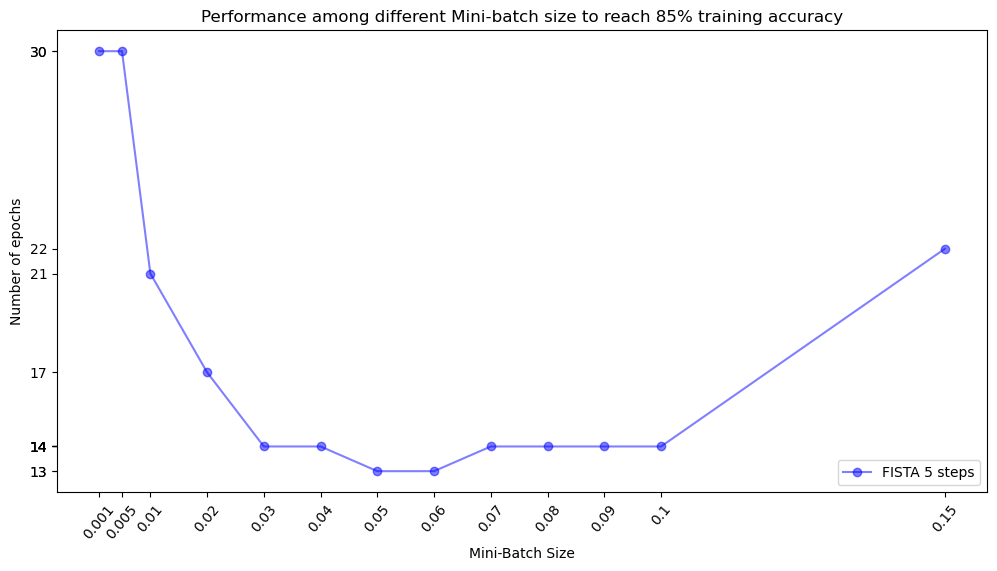

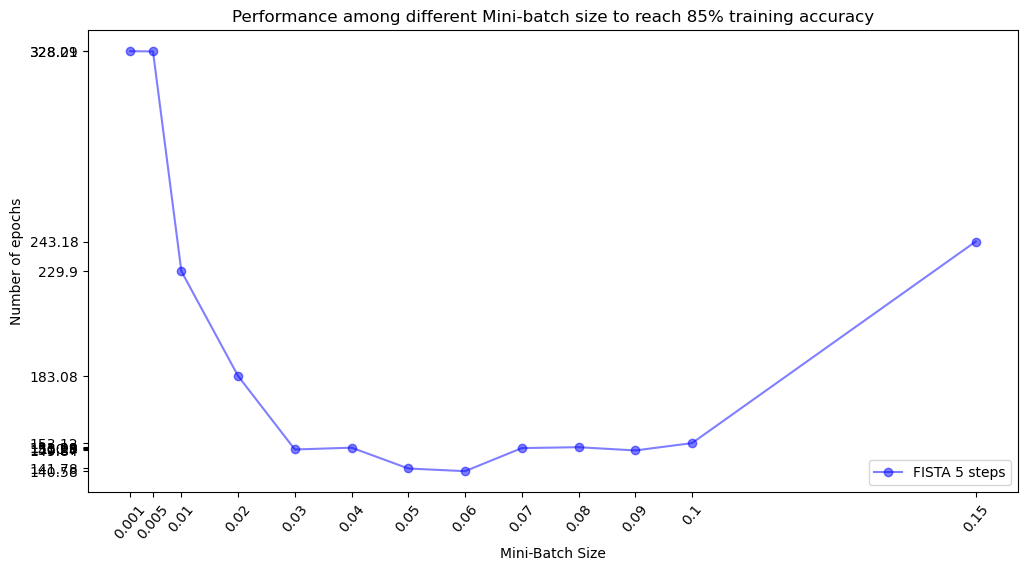

In [20]:
import os, json
import matplotlib.pyplot as plt

def load_performance(score_path):
    epochs = {}
    run_times = {}
    for root, dirs, files in os.walk(score_path):
        for file in files:
            if file.endswith('.json') and file.startswith('FISTA_'):
                if file.endswith('checkpoint.json'):
                    pass
                else:
                    with open(root+file, 'r') as f:
                        data = json.load(f)
                        lr = data['n_step']
                        n_epoch = len(data['train_losses'])
                        run_times[lr] = sum(data['run_time'])
                        epochs[lr] = n_epoch
    lrs = sorted(list(epochs.keys()))
    n_epochs = [epochs[k] for k in lrs]
    _run_time = [round(run_times[k], 2) for k in lrs]
    return lrs, n_epochs, _run_time

score_path_1 = "/home/tung5534/cnn_cifar/W08/fista_multi/scores/E30T85/"
batch_sizes_5steps, n_epochs_5steps, run_time_5steps = load_performance(score_path_1)


plt.figure(figsize=(12,6))
plt.plot(batch_sizes_5steps, n_epochs_5steps, marker='o', color='b', alpha=.5, label='FISTA 5 steps')
plt.xlabel('Mini-Batch Size')
plt.xticks(batch_sizes_5steps, labels=batch_sizes_5steps, rotation=50)
plt.ylabel('Number of epochs')
y_tickslabel = n_epochs_3steps
plt.yticks(y_tickslabel, labels=y_tickslabel, rotation=0)
plt.title('Performance among different Mini-batch size to reach 85% training accuracy')
plt.legend(loc= 'lower right')
# plt.grid()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(batch_sizes_5steps, run_time_5steps, marker='o', color='b', alpha=.5, label='FISTA 5 steps')
plt.xlabel('Mini-Batch Size')
plt.xticks(batch_sizes_5steps, labels=batch_sizes_5steps, rotation=50)
plt.ylabel('Number of epochs')
y_tickslabel = run_time_5steps
plt.yticks(y_tickslabel, labels=y_tickslabel, rotation=0)
plt.title('Performance among different Mini-batch size to reach 85% training accuracy')
plt.legend(loc= 'lower right')
# plt.grid()
plt.show()